In [1]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [2]:
from pprint import pprint
import numpy as np
import tensorflow as tf

# tf.enable_v2_behavior()
import tensorflow_probability as tfp

In [3]:
tfd = tfp.distributions

In [125]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# generate fake data

In [369]:
x_range = [-20, 60]


def load_dataset(n=150, add_noise=False):
    np.random.seed(43)

    x = np.linspace(*x_range, n)
    if add_noise:
        y = x ** 2 + np.random.uniform(-5, 5, size=x.shape[0]) * x
    else:
        y = x ** 2

    y_scaler = StandardScaler()
    #     y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y[..., np.newaxis])[..., 0]

    x_scaler = StandardScaler()
    #     x_scaler = MinMaxScaler()
    x = x_scaler.fit_transform(x[..., np.newaxis])[..., 0]

    return y, x[..., np.newaxis]


y, x = load_dataset(add_noise=True)

In [370]:
y.shape

(150,)

In [371]:
x.shape

(150, 1)

Text(0.5, 0, 'y')

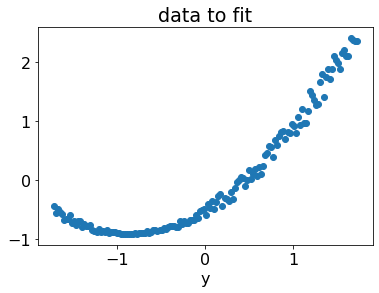

In [372]:
plt.figure()
plt.scatter(x, y)
plt.title("data to fit")
plt.xlabel("x")
plt.xlabel("y")

# Case 2 - Aleatoric (statistical) Uncertainty: / Known Unknowns

In [373]:
class PrintDot(tf.keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for 
    each completed epoch.
    """

    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0:
            print("")
        print(".", end="")

In [374]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [375]:
def run_case2_tfp_ann(x, y):
    def scheduler(epoch):

        if epoch > 1500:
            return 1e-5
        elif epoch > 1000:
            return 1e-4
        elif epoch > 500:
            return 1e-3 / 2
        else:
            return 1e-3

    scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks = [scheduler_callback, PrintDot()]

    #     activation = 'relu'
    activation = tf.keras.layers.LeakyReLU(alpha=0.3)

    model = tf.keras.Sequential(
        [
            # Here we have added another Neuron so we have TWO free parameters.
            # The second one will be used to model the standard deviation
            # the first parameter is t[...,:1] and the second is t[...,1:]
            # we write it like this to generalise to high dimensions and more parameters later
            tf.keras.layers.Dense(128, activation=activation),
            tf.keras.layers.Dense(128, activation=activation),
            tf.keras.layers.Dense(128, activation=activation),
            tf.keras.layers.Dense(1 + 1, activation="linear"),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :1],
                    scale=1e-3
                    + tf.math.softplus(0.05 * t[..., 1:]),  # ensure scale is positive
                )
            ),
        ]
    )
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    model.compile(loss=negloglik, optimizer=optimizer, metrics=["mae", "mse"])
    model.fit(x, y, epochs=2000, verbose=False, callbacks=callbacks)

    #     print("model weights")
    #     print("first set are for the location")
    #     print("second set are for the stdev")
    #     [print(np.squeeze(w.numpy())) for w in model.weights]
    #     gradient = model.weights[0].numpy().squeeze()
    #     y_intercept = model.weights[1].numpy().squeeze()

    #     print(f"gradient: {gradient:.5f}")
    #     print(f"y-intercept: {y_intercept:.5f}")

    return model

In [376]:
model = run_case2_tfp_ann(x, y)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [377]:
def plot(x, y, model):

    #     # instead of doing model.predict as you would normally
    #     # we instead just just call the model with the test set
    #     # which should return a tfd.Distribution object

    yhat = model(x)
    assert isinstance(yhat, tfd.Distribution)

    mean = yhat.mean()
    std = yhat.stddev()

    plt.figure(figsize=[14, 8])
    plt.scatter(x, y, label="data")

    for i, a_sample in enumerate(yhat.sample(10)):
        if i == 0:
            label = "sample"
        else:
            label = None
        plt.plot(x, a_sample, c="r", alpha=0.2, label=label)

    plt.plot(x, mean, label="mean", c="k", lw=2)

    plt.plot(x, mean - 2 * std, label="mean + 2 sigma", c="g", lw=2)
    plt.plot(x, mean + 2 * std, label="mean - 2 sigma", c="g", lw=2)

    plt.legend()
    plt.title("neural network with Gaussian output and modelled stdev")
    plt.xlabel("x")
    plt.xlabel("y")

    #     plt.xlim(-10,10)
    #     plt.ylim(-100, 100)

    plt.show()
    plt.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



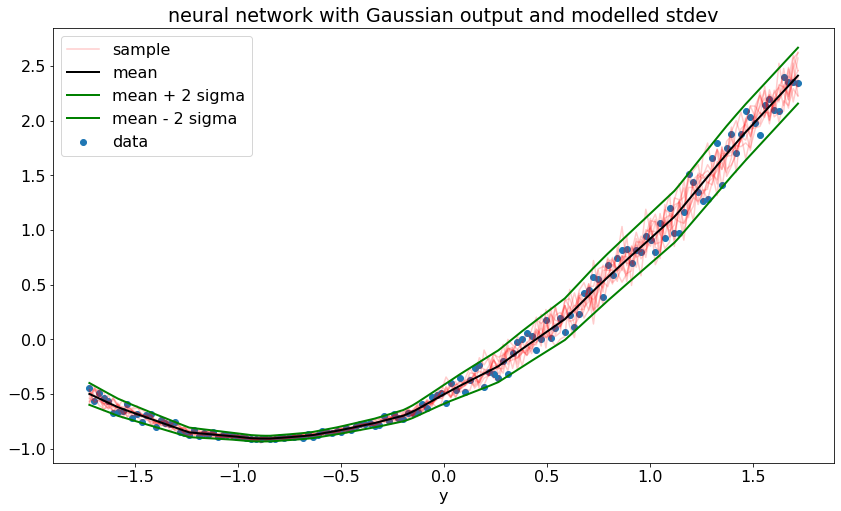

In [378]:
plot(x, y, model)

# try some other data

In [379]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scrinet.fits import scale

In [380]:
def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):

    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X >= xmin) & (X <= xmax)

    iy = IUS(X[mask], y[mask], k=k)

    Xnew = np.linspace(xmin, xmax, npts)

    return Xnew, iy(Xnew)

In [467]:
def resample_data_nonuniform(X, y, k=1):
    iy = IUS(X, y, k=k)

    #     bounds = [[X[0], 0.4, 5], [0.41, 0.6, 500], [0.61, X[-1], 400]]
    bounds = [[X[0], 0.3, 5], [0.31, 0.5, 800], [0.51, X[-1], 50]]

    for i, bound in enumerate(bounds):
        Xnew = np.linspace(*bound)
        ynew = iy(Xnew)

        if i == 0:
            total_X = Xnew
            total_y = ynew
        else:

            total_X = np.concatenate([total_X, Xnew])
            total_y = np.concatenate([total_y, ynew])

    return total_X, total_y

In [468]:
Xy = np.loadtxt("../../nn-fitting/1d-fitting/data_to_fit.txt")
X, y = Xy[np.argsort(Xy[:, 0])].T

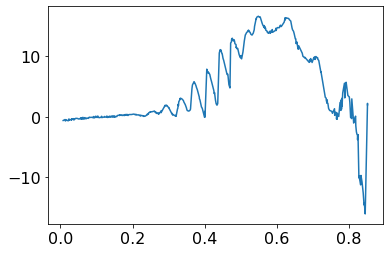

In [469]:
plt.figure()
plt.plot(X, y)

In [470]:
# X, y = resample_data(X, y, npts=2000)
X, y = resample_data_nonuniform(X, y)
# X = X[..., np.newaxis]
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

In [471]:
print(X.shape)
print(y.shape)

(855, 1)
(855, 1)


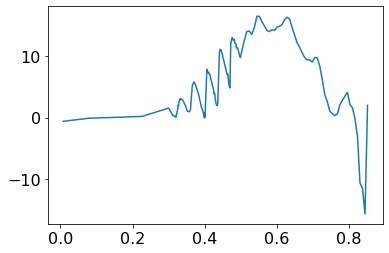

In [472]:
plt.figure()
plt.plot(X, y)

In [473]:
scaleX = True
scaleY = True
if scaleX:
    X = X.copy()
    X_scalers = scale.make_scalers(X)
    X = scale.apply_scaler(X, X_scalers)
if scaleY:
    y = y.copy()
    Y_scalers = scale.make_scalers(y)
    y = scale.apply_scaler(y, Y_scalers)

y = y[:, 0]

In [474]:
X.shape

(855, 1)

In [475]:
y.shape

(855,)

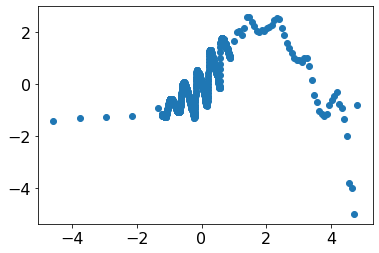

In [476]:
plt.figure()
plt.scatter(X, y)

In [477]:
%%time
model = run_case2_tfp_ann(X, y)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



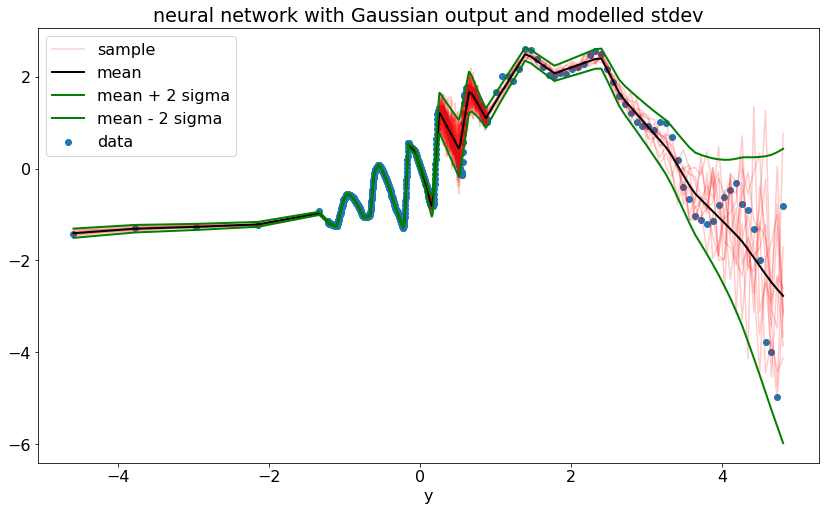

In [478]:
plot(X, y, model)